In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.20.0
Keras version: 3.11.3


In [20]:
# CONFIG

df_sensor = pd.read_csv('./data/final_dataset.csv')
df_windows = pd.read_csv('./data/final_window_labels.csv') 

concept_columns = {'periodicity', 'temporal_stability', 'coordination', 'motion_intensity', 'vertical_dominance'}
discrete_concepts = {'periodicity', 'temporal_stability', 'coordination'}
continuous_concepts = {'motion_intensity', 'vertical_dominance'}

activity_mapping = {act: i for i, act in enumerate(np.unique(df_windows["activity"].values))}

In [37]:
train_idx, test_idx = train_test_split(
    df_windows.index, test_size=0.25, random_state=42, stratify=df_windows['activity']
)

df_windows_train = df_windows.loc[train_idx].reset_index(drop=True)
df_windows_test  = df_windows.loc[test_idx].reset_index(drop=True)

# Part 1

In the first part we train the base concept predictor model -> this correlates to the `3_sensor_data_to_concepts.ipynb` notebook.
The goal of this is to take the x,y,z accelerometer data and predict the concepts defined.

In [6]:
print(f"Sensor data: {len(df_sensor)} readings")
print(f"Manual labels: {len(df_windows)} windows")

print(f"\nAvailable concepts: {concept_columns}")
print(f"\nConcept distributions:")

for concept in concept_columns:
    if concept not in df_windows.columns:
        print(f"  {concept}: (missing from data)")
        continue

    if concept in discrete_concepts:
        print(f"\n  [Discrete] {concept}:")
        print(df_windows[concept].value_counts(dropna=False))
    elif concept in continuous_concepts:
        print(f"\n  [Continuous] {concept}:")
        print(df_windows[concept].describe())
    else:
        print(f"\n  [Unknown type] {concept}:")
        print(df_windows[concept].head())

Sensor data: 8802 readings
Manual labels: 150 windows

Available concepts: {'motion_intensity', 'coordination', 'periodicity', 'temporal_stability', 'vertical_dominance'}

Concept distributions:

  [Continuous] motion_intensity:
count    150.000000
mean       0.331157
std        0.041124
min        0.277237
25%        0.304296
50%        0.316702
75%        0.338431
max        0.471138
Name: motion_intensity, dtype: float64

  [Discrete] coordination:
coordination
1.0    70
0.5    64
0.0    16
Name: count, dtype: int64

  [Discrete] periodicity:
periodicity
0.0    90
0.5    35
1.0    25
Name: count, dtype: int64

  [Discrete] temporal_stability:
temporal_stability
0.5    87
1.0    51
0.0    12
Name: count, dtype: int64

  [Continuous] vertical_dominance:
count    150.000000
mean       0.248287
std        0.080944
min        0.041401
25%        0.201228
50%        0.236932
75%        0.291116
max        0.562017
Name: vertical_dominance, dtype: float64


In [7]:
def extract_window_robust(df_sensor, window_row, time_tolerance=0.5):
    """
    Extract sensor data with time tolerance to handle mismatches.
    """
    user = window_row['user']
    activity = window_row['activity']
    start_time = window_row['start_time']
    end_time = window_row['end_time']
    
    # Get data for this user/activity
    user_activity_data = df_sensor[(df_sensor['user'] == user) & 
                                  (df_sensor['activity'] == activity)].copy()
    
    if len(user_activity_data) == 0:
        return None
    
    # Find data within time window with tolerance
    mask = ((user_activity_data['time_s'] >= start_time - time_tolerance) & 
            (user_activity_data['time_s'] <= end_time + time_tolerance))
    
    window_data = user_activity_data[mask]
    
    if len(window_data) < 10:  # Need minimum samples
        return None
    
    # Extract sensor readings
    sensor_data = window_data[['x-axis', 'y-axis', 'z-axis']].values
    
    # Pad or truncate to fixed length (e.g., 100 samples)
    target_length = 60
    if len(sensor_data) > target_length:
        # Randomly sample if too long
        indices = np.random.choice(len(sensor_data), target_length, replace=False)
        sensor_data = sensor_data[indices]
    elif len(sensor_data) < target_length:
        # Pad with last value if too short
        padding = np.tile(sensor_data[-1:], (target_length - len(sensor_data), 1))
        sensor_data = np.vstack([sensor_data, padding])
    
    return sensor_data

def extract_windows_robust(df_sensor, df_windows):
    """
    Extract all windows with robust time matching for 6 concepts.
    """
    X = []
    y_p = []  # periodicity
    y_t = []  # temporal_stability
    y_c = []  # coordination
    y_mi = [] # motion_intensity
    y_vd = [] # vertical_dominance
    
    for _, window_row in df_windows.iterrows():
        window_data = extract_window_robust(df_sensor, window_row)
        if window_data is not None:
            X.append(window_data)
            y_p.append(window_row['periodicity'])
            y_t.append(window_row['temporal_stability'])
            y_c.append(window_row['coordination'])
            y_mi.append(window_row['motion_intensity'])
            y_vd.append(window_row['vertical_dominance'])
    
    return np.array(X), np.array(y_p), np.array(y_t), np.array(y_c), np.array(y_mi), np.array(y_vd)

In [8]:
def augment_jitter(data, sigma=0.05):
    """Add random Gaussian noise to simulate sensor imperfections"""
    return data + np.random.normal(0, sigma, data.shape)

def augment_scaling(data, sigma=0.1):
    """Scale magnitude to simulate different movement intensities"""
    # Handle different data shapes
    if len(data.shape) == 3:
        factor = np.random.normal(1.0, sigma, (data.shape[0], 1, data.shape[2]))
    elif len(data.shape) == 2:
        factor = np.random.normal(1.0, sigma, (data.shape[0], data.shape[1]))
    else:
        factor = np.random.normal(1.0, sigma, data.shape)
    return data * factor

def augment_rotation(data):
    """Rotate 3D data to simulate different phone orientations"""
    angle = np.random.uniform(-np.pi/6, np.pi/6)  # ±30 degrees
    cos_a, sin_a = np.cos(angle), np.sin(angle)
    rotation_matrix = np.array([
        [cos_a, -sin_a, 0],
        [sin_a, cos_a, 0],
        [0, 0, 1]
    ])
    return np.dot(data, rotation_matrix.T)

def augment_dataset(X, y_p, y_t, y_c, y_mi, y_vd, factor=10):
    """
    Create augmented versions of the dataset for 7 concepts.
    
    Args:
        X: Original data (n_samples, timesteps, 3)
        y_p, y_t, y_c, y_mi, y_vd, y_sp, y_mag: Labels for seven concepts
        factor: Augmentation multiplier (10 = 10x more data)
    
    Returns:
        Augmented dataset with (factor+1) × original size
    """
    n_original = len(X)
    n_augmented = n_original * factor
    
    # Initialize augmented arrays
    X_aug = np.zeros((n_augmented, X.shape[1], X.shape[2]))
    y_p_aug = np.zeros(n_augmented)
    y_t_aug = np.zeros(n_augmented)
    y_c_aug = np.zeros(n_augmented)
    y_mi_aug = np.zeros(n_augmented)
    y_vd_aug = np.zeros(n_augmented)
    
    for i in range(n_augmented):
        # Randomly select original sample
        idx = np.random.randint(0, n_original)
        
        # Apply random augmentation
        aug_type = np.random.choice(['jitter', 'scaling', 'rotation', 'none'])
        
        if aug_type == 'jitter':
            X_aug[i] = augment_jitter(X[idx])
        elif aug_type == 'scaling':
            X_aug[i] = augment_scaling(X[idx])
        elif aug_type == 'rotation':
            X_aug[i] = augment_rotation(X[idx])
        else:  # none
            X_aug[i] = X[idx]
        
        # Copy labels
        y_p_aug[i] = y_p[idx]
        y_t_aug[i] = y_t[idx]
        y_c_aug[i] = y_c[idx]
        y_mi_aug[i] = y_mi[idx]
        y_vd_aug[i] = y_vd[idx]
    
    # Combine original and augmented data
    X_combined = np.vstack([X, X_aug])
    y_p_combined = np.concatenate([y_p, y_p_aug])
    y_t_combined = np.concatenate([y_t, y_t_aug])
    y_c_combined = np.concatenate([y_c, y_c_aug])
    y_mi_combined = np.concatenate([y_mi, y_mi_aug])
    y_vd_combined = np.concatenate([y_vd, y_vd_aug])
    
    return X_combined, y_p_combined, y_t_combined, y_c_combined, y_mi_combined, y_vd_combined

In [38]:
print("Extracting windows for TRAIN set...")
X_train_w, y_p_train_w, y_t_train_w, y_c_train_w, y_mi_train_w, y_vd_train_w = extract_windows_robust(df_sensor, df_windows_train)
print(f"Train windows extracted: {len(X_train_w)}  shape: {X_train_w.shape if len(X_train_w)>0 else None}")

print("Extracting windows for TEST set...")
X_test_w,  y_p_test_w,  y_t_test_w,  y_c_test_w,  y_mi_test_w,  y_vd_test_w  = extract_windows_robust(df_sensor, df_windows_test)
print(f"Test windows extracted: {len(X_test_w)}   shape: {X_test_w.shape if len(X_test_w)>0 else None}")

print("Train label distributions:")
print(f"  Periodicity: {np.bincount(y_p_train_w.astype(int))}")
print("Test label distributions:")
print(f"  Periodicity: {np.bincount(y_p_test_w.astype(int))}")

Extracting windows for TRAIN set...
Train windows extracted: 112  shape: (112, 60, 3)
Extracting windows for TEST set...
Test windows extracted: 38   shape: (38, 60, 3)
Train label distributions:
  Periodicity: [93 19]
Test label distributions:
  Periodicity: [32  6]


In [39]:
print("Augmenting TRAIN data...")
X_train_aug, y_p_train_aug, y_t_train_aug, y_c_train_aug, y_mi_train_aug, y_vd_train_aug = augment_dataset(
    X_train_w, y_p_train_w, y_t_train_w, y_c_train_w, y_mi_train_w, y_vd_train_w, factor=10
)

print(f"Original train: {len(X_train_w)} windows")
print(f"Augmented train: {len(X_train_aug)} windows")

Augmenting TRAIN data...
Original train: 112 windows
Augmented train: 1232 windows


In [40]:
# Convert labels to categorical
# Discrete (note: labels appear to be -1/0/1 scaled in original code: keep previous *2 if needed)
y_p_train_cat = to_categorical(y_p_train_aug * 2, num_classes=3)
y_t_train_cat = to_categorical(y_t_train_aug * 2, num_classes=3)
y_c_train_cat = to_categorical(y_c_train_aug * 2, num_classes=3)

# Continuous
y_mi_train_cat = y_mi_train_aug.astype(np.float32).reshape(-1, 1)
y_vd_train_cat = y_vd_train_aug.astype(np.float32).reshape(-1, 1)

# Test (use non-augmented test windows)
y_p_test_cat = to_categorical(y_p_test_w * 2, num_classes=3)
y_t_test_cat = to_categorical(y_t_test_w * 2, num_classes=3)
y_c_test_cat = to_categorical(y_c_test_w * 2, num_classes=3)

y_mi_test_cat = y_mi_test_w.astype(np.float32).reshape(-1, 1)
y_vd_test_cat = y_vd_test_w.astype(np.float32).reshape(-1, 1)

print("Labels converted to categorical format (train/test)")

Labels converted to categorical format (train/test)


In [41]:
def build_optimized_cnn(input_shape, n_classes_p, n_classes_t, n_classes_c):
    input_layer = layers.Input(shape=input_shape)
    
    x = layers.Conv1D(16, 3, activation='relu', padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    
    x = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    
    x = layers.Dropout(0.4)(x)
    
    # Discrete concepts
    periodicity = layers.Dense(n_classes_p, activation='softmax', name='periodicity')(x)
    temporal_stability = layers.Dense(n_classes_t, activation='softmax', name='temporal_stability')(x)
    coordination = layers.Dense(n_classes_c, activation='softmax', name='coordination')(x)
    
    # Continuous concepts
    motion_intensity = layers.Dense(1, activation='linear', name='motion_intensity')(x)
    vertical_dominance = layers.Dense(1, activation='linear', name='vertical_dominance')(x)
    
    model = models.Model(inputs=input_layer, outputs=[periodicity, temporal_stability, coordination, motion_intensity, vertical_dominance])
    
    return model


In [42]:
print("Building model...")
model = build_optimized_cnn(
    input_shape=(X_train_aug.shape[1], X_train_aug.shape[2]),
    n_classes_p=3, n_classes_t=3, n_classes_c=3
)

# Compile with appropriate loss weights
model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss={
            'periodicity': 'categorical_crossentropy',
            'temporal_stability': 'categorical_crossentropy',
            'coordination': 'categorical_crossentropy',
            'motion_intensity': 'mse',
            'vertical_dominance': 'mse'
        },
        loss_weights={
            'periodicity': 1.0,
            'temporal_stability': 1.0,
            'coordination': 1.0,
            'motion_intensity': 1.0,
            'vertical_dominance': 1.0
        },
        metrics={
            'periodicity': ['accuracy'],
            'temporal_stability': ['accuracy'],
            'coordination': ['accuracy'],
            'motion_intensity': ['mse'],
            'vertical_dominance': ['mse']
        }
    )
    

print(f"Model parameters: {model.count_params():,}")
model.summary()

Building model...
Model parameters: 1,259


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 60, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 60, 16)    │        160 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 16)    │         64 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 30, 16)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 30, 16)    │        784 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 16)    │         64 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16)        │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ periodicity (Dense) │ (None, 3)         │         51 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ temporal_stability  │ (None, 3)         │         51 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ coordination        │ (None, 3)         │         51 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ motion_intensity    │ (None, 1)         │         17 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vertical_dominance  │ (None, 1)         │         17 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,259 (4.92 KB)

 Trainable params: 1,195 (4.67 KB)

 Non-trainable params: 64 (256.00 B)

In [43]:
print("Training model...")
history = model.fit(
    X_train_aug,
    [y_p_train_cat, y_t_train_cat, y_c_train_cat, y_mi_train_cat, y_vd_train_cat],
    validation_data=(X_test_w, [y_p_test_cat, y_t_test_cat, y_c_test_cat, y_mi_test_cat, y_vd_test_cat]),
    epochs=200,
    batch_size=32,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
    ]
)

print("Training completed!")

Training model...
Epoch 1/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - coordination_accuracy: 0.3766 - coordination_loss: 1.2047 - loss: 5.3413 - motion_intensity_loss: 1.1523 - motion_intensity_mse: 1.1567 - periodicity_accuracy: 0.3774 - periodicity_loss: 1.3122 - temporal_stability_accuracy: 0.4781 - temporal_stability_loss: 1.0520 - vertical_dominance_loss: 0.6079 - vertical_dominance_mse: 0.6119 - val_coordination_accuracy: 0.5789 - val_coordination_loss: 0.8006 - val_loss: 4.8524 - val_motion_intensity_loss: 0.1030 - val_motion_intensity_mse: 0.1282 - val_periodicity_accuracy: 0.6053 - val_periodicity_loss: 1.1399 - val_temporal_stability_accuracy: 0.6053 - val_temporal_stability_loss: 1.1191 - val_vertical_dominance_loss: 1.5099 - val_vertical_dominance_mse: 1.4972 - learning_rate: 0.0010
Epoch 2/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - coordination_accuracy: 0.5065 - coordination_loss: 0.9863 - loss: 3.9041 - motion_intensity_loss: 0.5505 - motion_intensity_mse: 0.5535 - p

In [44]:
def calculate_auroc_multi_output(y_true_categorical, y_pred_proba, concept_name, num_classes):
    """
    Calculate AUROC for multi-output CNN concepts
    
    Args:
        y_true_categorical: True labels in categorical format
        y_pred_proba: Predicted probabilities from model
        concept_name: Name of the concept (for discrete concepts only)
        num_classes: Number of classes for this concept
    
    Returns:
        AUROC score
    """
    # Convert categorical to integer labels
    y_true = np.argmax(y_true_categorical, axis=1)
    
    # For binary classification (2 classes)
    if num_classes == 2:
        # Use the probability of the positive class
        y_scores = y_pred_proba[:, 1]
        return roc_auc_score(y_true, y_scores)
    else:
        # Binarize the labels for multi-class AUROC calculation
        y_true_bin = label_binarize(y_true, classes=range(num_classes))
        
        if y_true_bin.shape[1] == 1:
            # Binary case
            return roc_auc_score(y_true_bin, y_pred_proba[:, 1])
        else:
            # Multi-class case
            return roc_auc_score(y_true_bin, y_pred_proba, multi_class='ovr', average='macro')

In [45]:
y_test_map = {
    'periodicity': y_p_test_cat,
    'temporal_stability': y_t_test_cat,
    'coordination': y_c_test_cat,
    'motion_intensity': y_mi_test_cat,
    'vertical_dominance': y_vd_test_cat,
}

print("Evaluating model...")
results = model.evaluate(X_test_w, list(y_test_map.values()), verbose=0)

predictions = model.predict(X_test_w, verbose=0)
periodicity_pred = np.argmax(predictions[0], axis=1)
temporal_stability_pred = np.argmax(predictions[1], axis=1)
coordination_pred = np.argmax(predictions[2], axis=1)
motion_intensity_pred = predictions[3].flatten()
vertical_dominance_pred = predictions[4].flatten()

periodicity_acc = accuracy_score(np.argmax(y_p_test_cat, axis=1), periodicity_pred)
temporal_stability_acc = accuracy_score(np.argmax(y_t_test_cat, axis=1), temporal_stability_pred)
coordination_acc = accuracy_score(np.argmax(y_c_test_cat, axis=1), coordination_pred)

periodicity_auroc = calculate_auroc_multi_output(y_p_test_cat, predictions[0], 'periodicity', 3)
temporal_stability_auroc = calculate_auroc_multi_output(y_t_test_cat, predictions[1], 'temporal_stability', 3)
coordination_auroc = calculate_auroc_multi_output(y_c_test_cat, predictions[2], 'coordination', 3)

from sklearn.metrics import r2_score, mean_squared_error
motion_intensity_r2 = r2_score(y_mi_test_cat.flatten(), motion_intensity_pred)
vertical_dominance_r2 = r2_score(y_vd_test_cat.flatten(), vertical_dominance_pred)
motion_intensity_mse = mean_squared_error(y_mi_test_cat.flatten(), motion_intensity_pred)
vertical_dominance_mse = mean_squared_error(y_vd_test_cat.flatten(), vertical_dominance_pred)

overall_acc = (periodicity_acc + temporal_stability_acc + coordination_acc) / 3.0

auroc_scores = [periodicity_auroc, temporal_stability_auroc, coordination_auroc]
valid_auroc_scores = [score for score in auroc_scores if not np.isnan(score)]
overall_auroc = np.mean(valid_auroc_scores) if valid_auroc_scores else 0.5

print(f"\n=== RESULTS ===")
print(f"\n--- Classification Concepts (Discrete) ---")
print(f"Periodicity - Accuracy: {periodicity_acc:.4f}, AUROC: {periodicity_auroc:.4f}")
print(f"Temporal Stability - Accuracy: {temporal_stability_acc:.4f}, AUROC: {temporal_stability_auroc:.4f}")
print(f"Coordination - Accuracy: {coordination_acc:.4f}, AUROC: {coordination_auroc:.4f}")

print(f"\n--- Regression Concepts (Continuous) ---")
print(f"Motion Intensity - R²: {motion_intensity_r2:.4f}, MSE: {motion_intensity_mse:.4f}")
print(f"Vertical Dominance - R²: {vertical_dominance_r2:.4f}, MSE: {vertical_dominance_mse:.4f}")

print(f"\n--- Overall Performance ---")
print(f"Overall Average Accuracy (classification concepts): {overall_acc*100:.1f}%")
print(f"Overall Average AUROC (classification concepts): {overall_auroc:.4f}")

Evaluating model...

=== RESULTS ===

--- Classification Concepts (Discrete) ---
Periodicity - Accuracy: 0.6842, AUROC: 0.8392
Temporal Stability - Accuracy: 0.7368, AUROC: 0.8595
Coordination - Accuracy: 0.7632, AUROC: 0.8668

--- Regression Concepts (Continuous) ---
Motion Intensity - R²: -4.8701, MSE: 0.0107
Vertical Dominance - R²: 0.1909, MSE: 0.0049

--- Overall Performance ---
Overall Average Accuracy (classification concepts): 72.8%
Overall Average AUROC (classification concepts): 0.8552


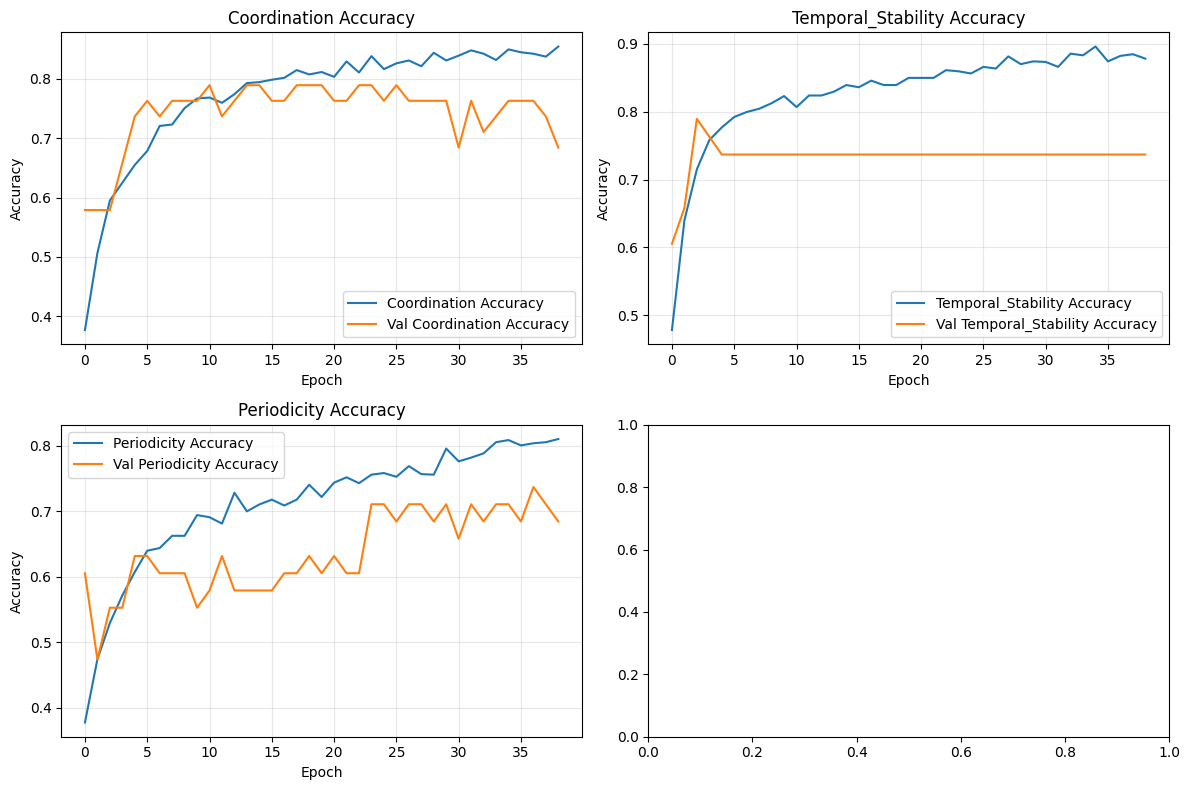

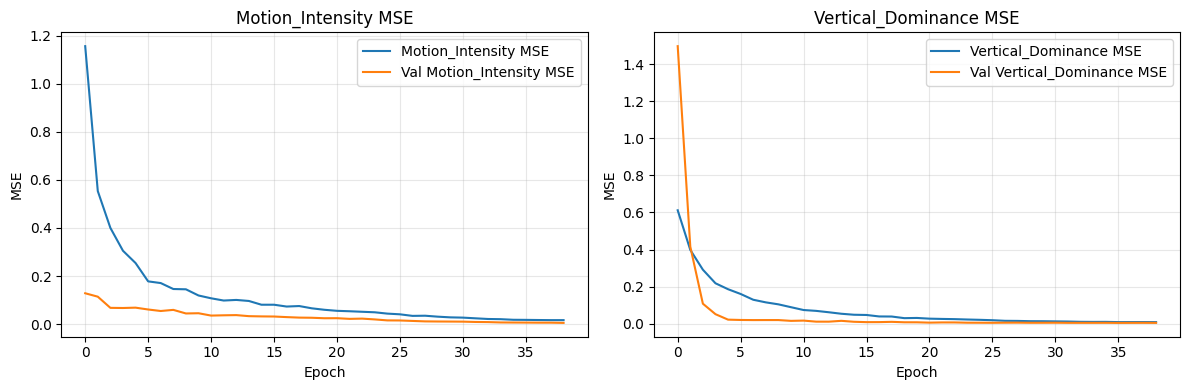

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, concept in enumerate(discrete_concepts):
    row, col = i // 2, i % 2
    axes[row, col].plot(history.history[f'{concept}_accuracy'], label=f'{concept.title()} Accuracy')
    axes[row, col].plot(history.history[f'val_{concept}_accuracy'], label=f'Val {concept.title()} Accuracy')
    axes[row, col].set_title(f'{concept.title()} Accuracy')
    axes[row, col].set_xlabel('Epoch')
    axes[row, col].set_ylabel('Accuracy')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, concept in enumerate(continuous_concepts):
    axes[i].plot(history.history[f'{concept}_mse'], label=f'{concept.title()} MSE')
    axes[i].plot(history.history[f'val_{concept}_mse'], label=f'Val {concept.title()} MSE')
    axes[i].set_title(f'{concept.title()} MSE')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('MSE')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Part 2

This part corresponds to the `4_concept_to_true_labels.ipynb`. The goal of this part is to build a model, in this case we chose to use a LogisicRegression model as that yielded the best results. The analysis of the different models can be seen in the 4th notebook.

In [47]:
def calculate_auroc(y_true, y_pred_proba, num_classes):
    y_true_bin = label_binarize(y_true, classes=range(num_classes))
    
    if y_true_bin.shape[1] == 1:
        return roc_auc_score(y_true_bin, y_pred_proba[:, 1])
    else:
        return roc_auc_score(y_true_bin, y_pred_proba, multi_class='ovr', average='macro')

In [48]:
X_final_train = df_windows_train[list(concept_columns)].values
X_final_test  = df_windows_test[list(concept_columns)].values

y_train = np.array([activity_mapping[act] for act in df_windows_train['activity'].values])
y_test  = np.array([activity_mapping[act] for act in df_windows_test['activity'].values])

num_classes = len(activity_mapping)

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_final_train, y_train)

y_pred_lr = lr.predict(X_final_test)
y_pred_proba_lr = lr.predict_proba(X_final_test)

print("=== Logistic Regression (trained on GT concepts from TRAIN split) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("AUROC:", calculate_auroc(y_test, y_pred_proba_lr, num_classes))
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))

=== Logistic Regression (trained on GT concepts from TRAIN split) ===
Accuracy: 0.39473684210526316
AUROC: 0.8705837173579108
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.25      0.29      0.27         7
           2       0.83      0.83      0.83         6
           3       0.50      0.83      0.62         6
           4       0.38      0.50      0.43         6
           5       0.00      0.00      0.00         7

    accuracy                           0.39        38
   macro avg       0.33      0.41      0.36        38
weighted avg       0.32      0.39      0.35        38

[[0 0 0 2 3 1]
 [0 2 0 1 1 3]
 [0 0 5 1 0 0]
 [0 0 1 5 0 0]
 [0 0 0 1 3 2]
 [0 6 0 0 1 0]]


# Part 3

The goal of this part is to combine the two previous parts together and see the full CBM in action, while also displaying the proper visualizations.

In [81]:

concept_order = ['periodicity','temporal_stability','coordination','motion_intensity','vertical_dominance']

X_test_filtered = []
y_test_aligned = []
X_final_test_aligned = []
rows_filtered = []

print("Extracting test windows...")
for _, row in df_windows_test.iterrows():
    wd = extract_window_robust(df_sensor, row)
    if wd is not None:
        X_test_filtered.append(wd)
        y_test_aligned.append(activity_mapping[row['activity']])
        X_final_test_aligned.append([row[col] for col in concept_order])
        rows_filtered.append(row)

if len(X_test_filtered) == 0:
    print("No test windows available after extraction. This shouldn't happen.")
    raise SystemExit

X_test_filtered = np.array(X_test_filtered)
y_test_aligned = np.array(y_test_aligned)
X_final_test_aligned = np.array(X_final_test_aligned)

print(f"Successfully extracted {len(X_test_filtered)} test windows")

print(f"\n=== RESULTS CNN ===")

predictions = model.predict(X_test_filtered, verbose=0)

# Extract predictions correctly
periodicity_pred = np.argmax(predictions[0], axis=1)
temporal_stability_pred = np.argmax(predictions[1], axis=1)
coordination_pred = np.argmax(predictions[2], axis=1)
# For continuous concepts, use the raw values, not argmax
motion_intensity_pred = predictions[3].flatten()
vertical_dominance_pred = predictions[4].flatten()

# Get ground truth labels for comparison
y_p_gt = np.array([int(row['periodicity'] * 2) for row in rows_filtered])
y_t_gt = np.array([int(row['temporal_stability'] * 2) for row in rows_filtered])
y_c_gt = np.array([int(row['coordination'] * 2) for row in rows_filtered])
y_mi_gt = np.array([row['motion_intensity'] for row in rows_filtered])
y_vd_gt = np.array([row['vertical_dominance'] for row in rows_filtered])

# Calculate accuracies for discrete concepts
periodicity_acc = accuracy_score(y_p_gt, periodicity_pred)
temporal_stability_acc = accuracy_score(y_t_gt, temporal_stability_pred)
coordination_acc = accuracy_score(y_c_gt, coordination_pred)

# Calculate AUROC for discrete concepts
periodicity_auroc = calculate_auroc_multi_output(
    to_categorical(y_p_gt, num_classes=3), predictions[0], 'periodicity', 3
)
temporal_stability_auroc = calculate_auroc_multi_output(
    to_categorical(y_t_gt, num_classes=3), predictions[1], 'temporal_stability', 3
)
coordination_auroc = calculate_auroc_multi_output(
    to_categorical(y_c_gt, num_classes=3), predictions[2], 'coordination', 3
)

# Calculate R² for continuous concepts
motion_intensity_r2 = r2_score(y_mi_gt, motion_intensity_pred)
vertical_dominance_r2 = r2_score(y_vd_gt, vertical_dominance_pred)

overall_acc = (periodicity_acc + temporal_stability_acc + coordination_acc) / 3.0

auroc_scores = [periodicity_auroc, temporal_stability_auroc, coordination_auroc]
valid_auroc_scores = [score for score in auroc_scores if not np.isnan(score)]
overall_auroc = np.mean(valid_auroc_scores) if valid_auroc_scores else 0.5

print(f"\n--- Classification Concepts (Discrete) ---")
print(f"Periodicity - Accuracy: {periodicity_acc:.4f}, AUROC: {periodicity_auroc:.4f}")
print(f"Temporal Stability - Accuracy: {temporal_stability_acc:.4f}, AUROC: {temporal_stability_auroc:.4f}")
print(f"Coordination - Accuracy: {coordination_acc:.4f}, AUROC: {coordination_auroc:.4f}")

print(f"\n--- Regression Concepts (Continuous) ---")
print(f"Motion Intensity - R²: {motion_intensity_r2:.4f}")
print(f"Vertical Dominance - R²: {vertical_dominance_r2:.4f}")

print(f"\n--- Overall Performance ---")
print(f"Overall Average Accuracy (classification concepts): {overall_acc*100:.1f}%")
print(f"Overall Average AUROC (classification concepts): {overall_auroc:.4f}")

print(f"\n=== RESULTS LOGISTIC REGRESSION ===")

X_final_test_original = df_windows_test[list(concept_columns)].values
y_test_original = np.array([activity_mapping[act] for act in df_windows_test['activity'].values])

X_final_test_aligned_corrected = df_windows_test[list(concept_columns)].values

print(f"Original test set size: {len(X_final_test_original)}")
print(f"Filtered test set size: {len(X_final_test_aligned)}")
print(f"Test set size difference: {len(X_final_test_original) - len(X_final_test_aligned)}")

y_pred_lr_gt_filtered = lr.predict(X_final_test_aligned_corrected)
y_pred_proba_lr_gt_filtered = lr.predict_proba(X_final_test_aligned_corrected)

print("\n=== GT Concepts -> LR ===")
print("Accuracy:", accuracy_score(y_test_original, y_pred_lr_gt_filtered))
print("AUROC:", calculate_auroc(y_test_original, y_pred_proba_lr_gt_filtered, num_classes))


concept_columns_list = list(concept_columns)

concept_order_to_training = [concept_order.index(col) for col in concept_columns_list]

predicted_concepts_ordered = np.column_stack([
    periodicity_pred / 2.0,
    temporal_stability_pred / 2.0,
    coordination_pred / 2.0,
    motion_intensity_pred,
    vertical_dominance_pred
])

predicted_concepts_matrix = predicted_concepts_ordered[:, concept_order_to_training]

y_pred_lr_cnn = lr.predict(predicted_concepts_matrix)
y_pred_proba_lr_cnn = lr.predict_proba(predicted_concepts_matrix)

print("\n=== CNN Concepts -> LR (Our Pipeline) ===")
print("Accuracy:", accuracy_score(y_test_original, y_pred_lr_cnn))
print("AUROC:", calculate_auroc(y_test_original, y_pred_proba_lr_cnn, num_classes))

Extracting test windows...
Successfully extracted 38 test windows

=== RESULTS CNN ===

--- Classification Concepts (Discrete) ---
Periodicity - Accuracy: 0.6579, AUROC: 0.8262
Temporal Stability - Accuracy: 0.7368, AUROC: 0.8671
Coordination - Accuracy: 0.7895, AUROC: 0.8649

--- Regression Concepts (Continuous) ---
Motion Intensity - R²: -4.8384
Vertical Dominance - R²: 0.2043

--- Overall Performance ---
Overall Average Accuracy (classification concepts): 72.8%
Overall Average AUROC (classification concepts): 0.8527

=== RESULTS LOGISTIC REGRESSION ===
Original test set size: 38
Filtered test set size: 38
Test set size difference: 0

=== GT Concepts -> LR ===
Accuracy: 0.39473684210526316
AUROC: 0.8705837173579108

=== CNN Concepts -> LR (Our Pipeline) ===
Accuracy: 0.6052631578947368
AUROC: 0.8438060035842293


In [78]:
# Ensure we have all the necessary variables from the previous cell
# If they're not available, we need to recreate them
if 'y_pred_lr_gt_original' not in locals():
    print("Recreating missing variables...")
    
    # Use the exact same test split as in the original training
    X_final_test_original = df_windows_test[list(concept_columns)].values
    y_test_original = np.array([activity_mapping[act] for act in df_windows_test['activity'].values])
    
    # Test with original test split (same as training)
    y_pred_lr_gt_original = lr.predict(X_final_test_original)
    y_pred_proba_lr_gt_original = lr.predict_proba(X_final_test_original)
    
    # Create concept matrix from CNN predictions with correct column order
    concept_columns_list = list(concept_columns)
    concept_order_to_training = [concept_order.index(col) for col in concept_columns_list]
    
    predicted_concepts_ordered = np.column_stack([
        periodicity_pred / 2.0,  # Convert back to 0-1 scale
        temporal_stability_pred / 2.0,
        coordination_pred / 2.0,
        motion_intensity_pred,
        vertical_dominance_pred
    ])
    
    # Reorder columns to match training order
    predicted_concepts_matrix = predicted_concepts_ordered[:, concept_order_to_training]
    
    # Test with CNN-predicted concepts (our pipeline)
    y_pred_lr_cnn = lr.predict(predicted_concepts_matrix)
    y_pred_proba_lr_cnn = lr.predict_proba(predicted_concepts_matrix)
    
    print("Variables recreated successfully!")
else:
    print("Variables already available!")


Variables already available!


DETAILED WINDOW-BY-WINDOW ANALYSIS
Analyzing 5 test windows...

📱 WINDOW 1/5
--------------------------------------------------
👤 User: 7
⏰ Time: 133.5s - 136.5s
🏃 Activity: Upstairs (Ground Truth)

📊 GROUND TRUTH CONCEPTS:
   Periodicity: 0.0
   Temporal Stability: 0.5
   Coordination: 1.0
   Motion Intensity: 0.3375
   Vertical Dominance: 0.1390

🧠 CNN PREDICTED CONCEPTS:
   Periodicity: 0 (confidence: 0.510)
   Temporal Stability: 1 (confidence: 0.625)
   Coordination: 2 (confidence: 0.712)
   Motion Intensity: 0.1880
   Vertical Dominance: 0.2284

✅ CONCEPT PREDICTION ACCURACY:
   Periodicity: ✅
   Temporal Stability: ✅
   Coordination: ✅
   Motion Intensity: Error = 0.1495
   Vertical Dominance: Error = 0.0894

ACTIVITY PREDICTIONS:
   Ground Truth: Upstairs
   CNN→LR: Standing (confidence: 0.275)
   GT→LR: Standing (confidence: 0.286)

🎯 ACTIVITY PREDICTION ACCURACY:
   CNN→LR: ❌
   GT→LR: ❌

📈 TOP 3 ACTIVITY PROBABILITIES (CNN→LR):
   1. Standing: 0.275
   2. Sitting: 0.210
   3

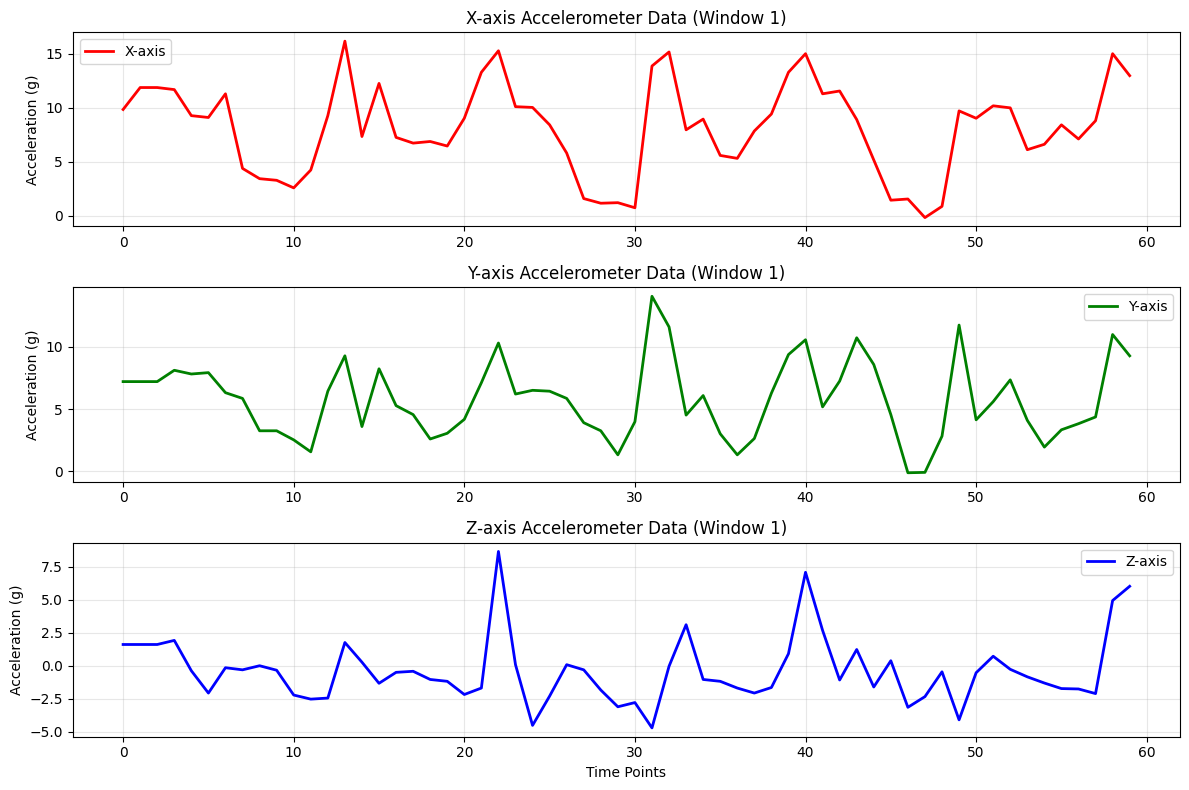

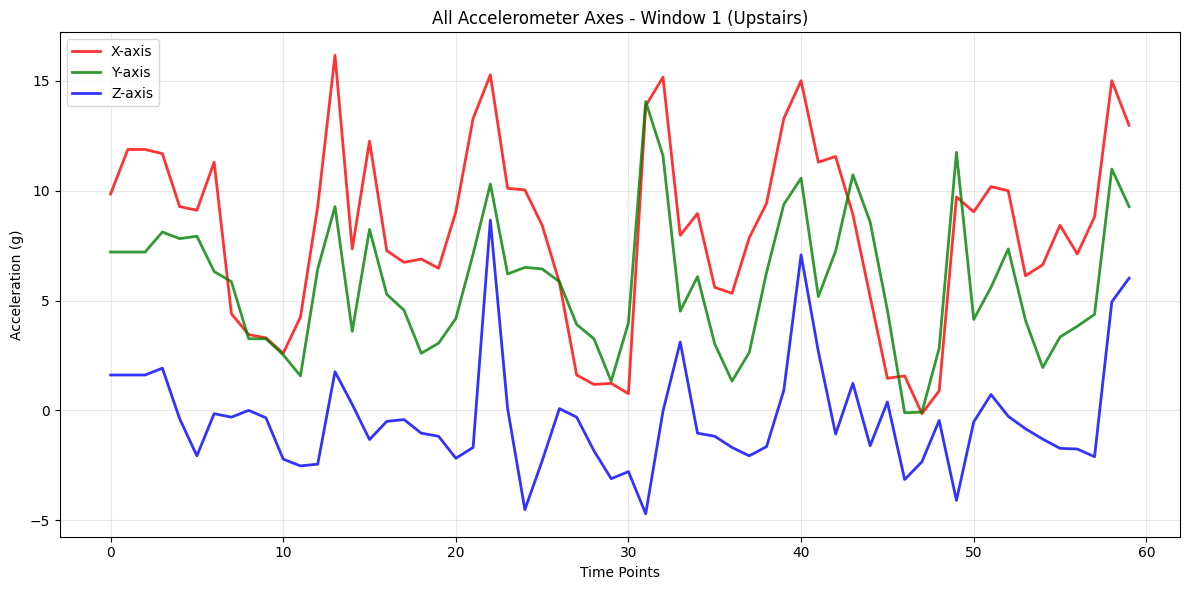


📈 ACCELEROMETER STATISTICS:
   X-axis: Mean=8.158, Std=4.160
   Y-axis: Mean=5.760, Std=3.067
   Z-axis: Mean=-0.378, Std=2.506
   Magnitude: Mean=10.500, Std=4.755

📱 WINDOW 2/5
--------------------------------------------------
👤 User: 6
⏰ Time: 5.2s - 8.2s
🏃 Activity: Standing (Ground Truth)

📊 GROUND TRUTH CONCEPTS:
   Periodicity: 0.0
   Temporal Stability: 0.5
   Coordination: 1.0
   Motion Intensity: 0.3196
   Vertical Dominance: 0.1458

🧠 CNN PREDICTED CONCEPTS:
   Periodicity: 0 (confidence: 0.867)
   Temporal Stability: 1 (confidence: 0.613)
   Coordination: 2 (confidence: 0.393)
   Motion Intensity: 0.4342
   Vertical Dominance: 0.2472

✅ CONCEPT PREDICTION ACCURACY:
   Periodicity: ✅
   Temporal Stability: ✅
   Coordination: ✅
   Motion Intensity: Error = 0.1146
   Vertical Dominance: Error = 0.1014

ACTIVITY PREDICTIONS:
   Ground Truth: Standing
   CNN→LR: Standing (confidence: 0.264)
   GT→LR: Standing (confidence: 0.285)

🎯 ACTIVITY PREDICTION ACCURACY:
   CNN→LR: ✅
  

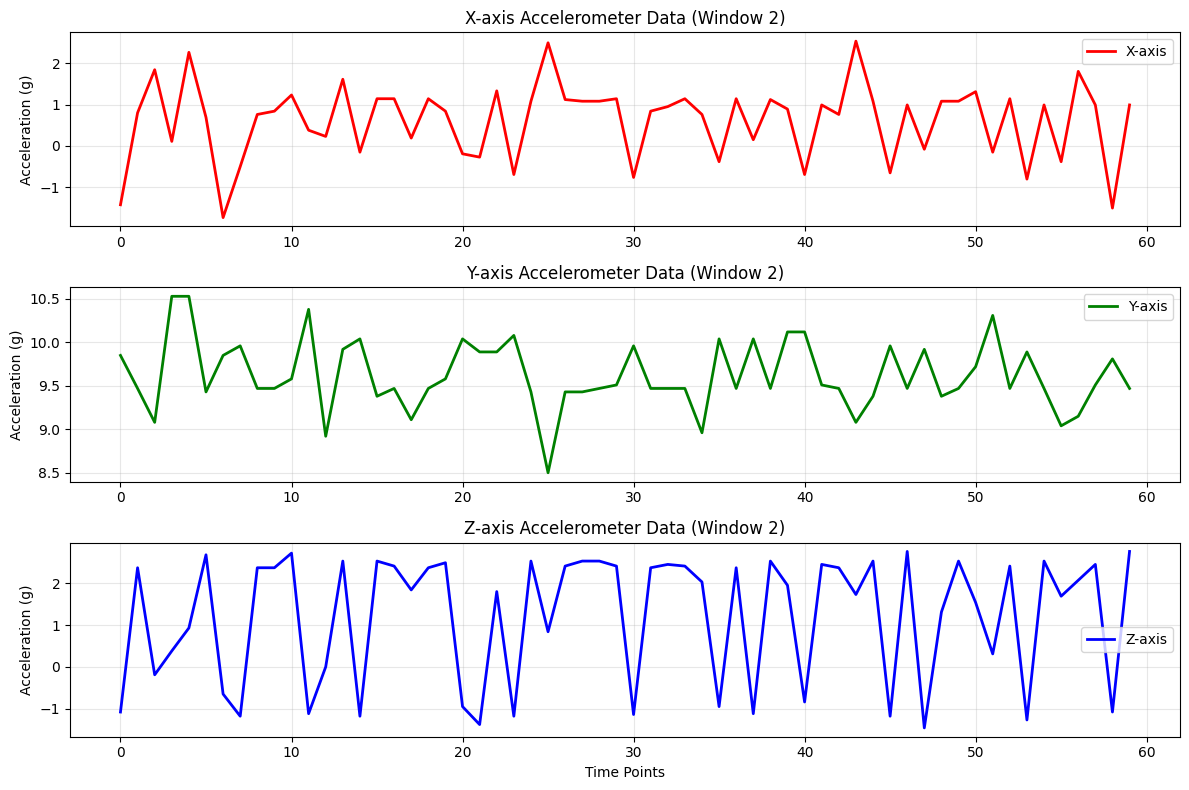

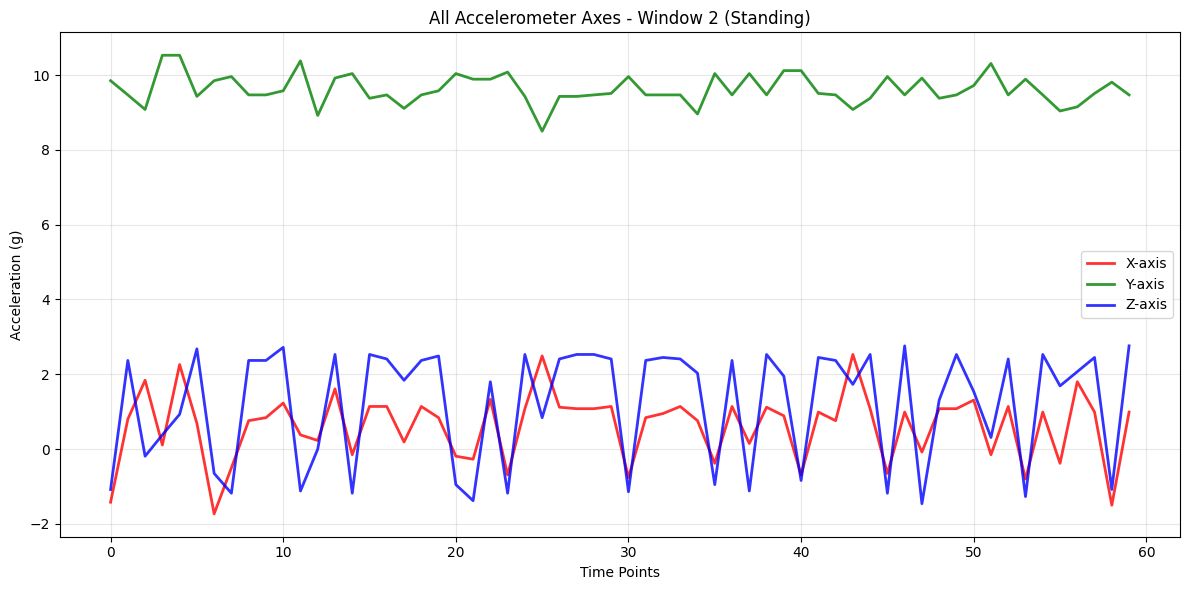


📈 ACCELEROMETER STATISTICS:
   X-axis: Mean=0.615, Std=0.915
   Y-axis: Mean=9.620, Std=0.395
   Z-axis: Mean=1.211, Std=1.544
   Magnitude: Mean=9.882, Std=0.337

📱 WINDOW 3/5
--------------------------------------------------
👤 User: 6
⏰ Time: 11.2s - 14.2s
🏃 Activity: Sitting (Ground Truth)

📊 GROUND TRUTH CONCEPTS:
   Periodicity: 0.0
   Temporal Stability: 1.0
   Coordination: 1.0
   Motion Intensity: 0.2994
   Vertical Dominance: 0.4523

🧠 CNN PREDICTED CONCEPTS:
   Periodicity: 0 (confidence: 0.969)
   Temporal Stability: 2 (confidence: 0.965)
   Coordination: 2 (confidence: 0.987)
   Motion Intensity: 0.3493
   Vertical Dominance: 0.3201

✅ CONCEPT PREDICTION ACCURACY:
   Periodicity: ✅
   Temporal Stability: ✅
   Coordination: ✅
   Motion Intensity: Error = 0.0499
   Vertical Dominance: Error = 0.1323

ACTIVITY PREDICTIONS:
   Ground Truth: Sitting
   CNN→LR: Sitting (confidence: 0.407)
   GT→LR: Sitting (confidence: 0.462)

🎯 ACTIVITY PREDICTION ACCURACY:
   CNN→LR: ✅
   GT→

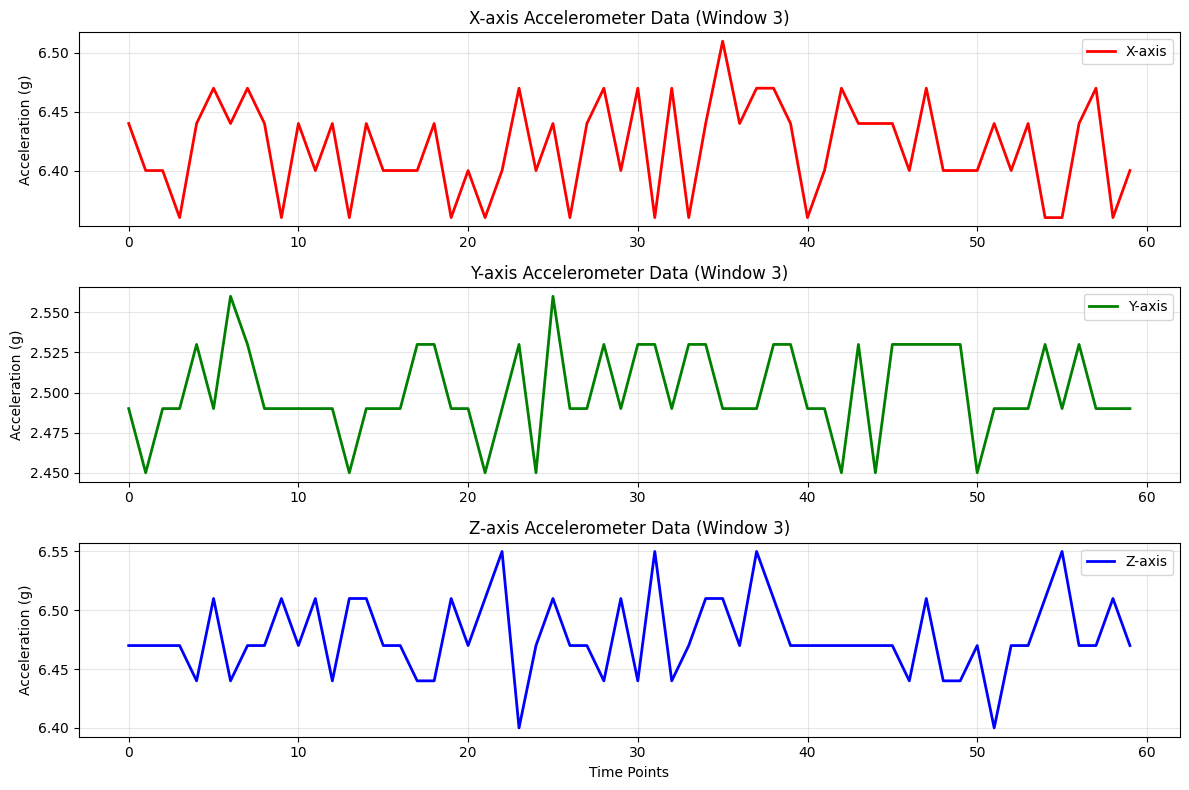

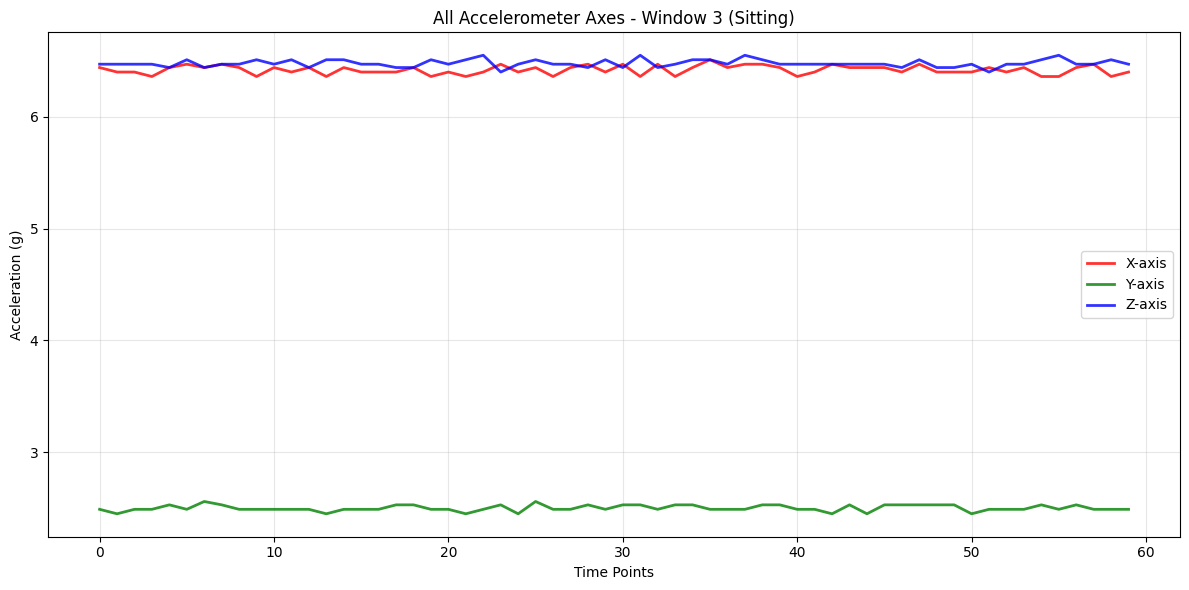


📈 ACCELEROMETER STATISTICS:
   X-axis: Mean=6.419, Std=0.039
   Y-axis: Mean=2.501, Std=0.028
   Z-axis: Mean=6.478, Std=0.033
   Magnitude: Mean=9.456, Std=0.032

📱 WINDOW 4/5
--------------------------------------------------
👤 User: 12
⏰ Time: 82.5s - 85.5s
🏃 Activity: Sitting (Ground Truth)

📊 GROUND TRUTH CONCEPTS:
   Periodicity: 0.0
   Temporal Stability: 1.0
   Coordination: 1.0
   Motion Intensity: 0.3384
   Vertical Dominance: 0.2307

🧠 CNN PREDICTED CONCEPTS:
   Periodicity: 0 (confidence: 0.955)
   Temporal Stability: 2 (confidence: 0.986)
   Coordination: 2 (confidence: 0.996)
   Motion Intensity: 0.2307
   Vertical Dominance: 0.3132

✅ CONCEPT PREDICTION ACCURACY:
   Periodicity: ✅
   Temporal Stability: ✅
   Coordination: ✅
   Motion Intensity: Error = 0.1076
   Vertical Dominance: Error = 0.0824

ACTIVITY PREDICTIONS:
   Ground Truth: Sitting
   CNN→LR: Sitting (confidence: 0.406)
   GT→LR: Standing (confidence: 0.397)

🎯 ACTIVITY PREDICTION ACCURACY:
   CNN→LR: ✅
   G

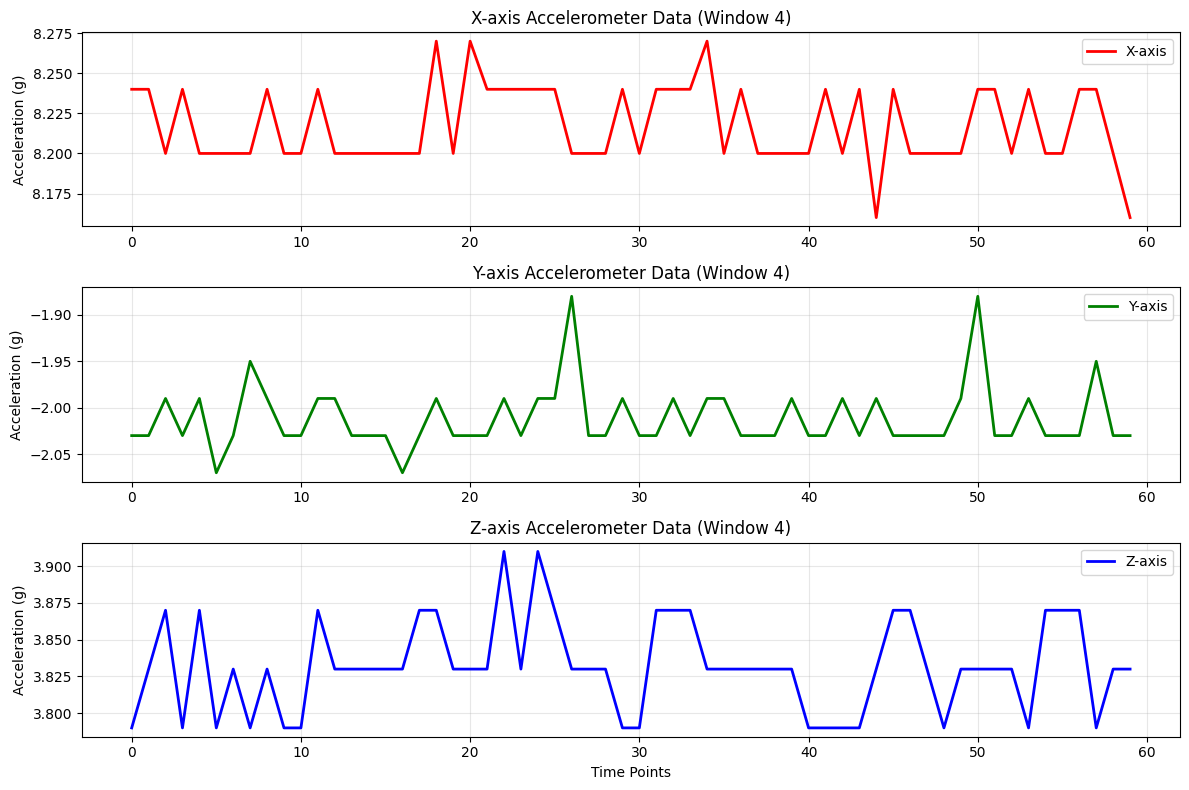

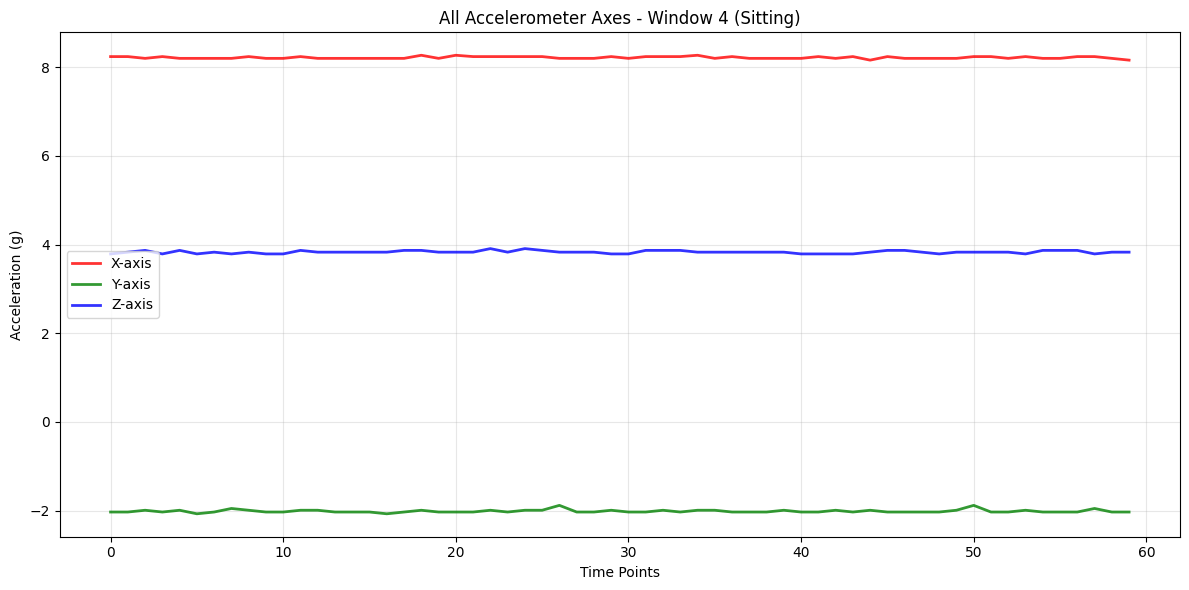


📈 ACCELEROMETER STATISTICS:
   X-axis: Mean=8.218, Std=0.025
   Y-axis: Mean=-2.012, Std=0.034
   Z-axis: Mean=3.832, Std=0.031
   Magnitude: Mean=9.288, Std=0.027

📱 WINDOW 5/5
--------------------------------------------------
👤 User: 7
⏰ Time: 798.8s - 801.8s
🏃 Activity: Jogging (Ground Truth)

📊 GROUND TRUTH CONCEPTS:
   Periodicity: 1.0
   Temporal Stability: 1.0
   Coordination: 0.5
   Motion Intensity: 0.4580
   Vertical Dominance: 0.2574

🧠 CNN PREDICTED CONCEPTS:
   Periodicity: 2 (confidence: 0.518)
   Temporal Stability: 1 (confidence: 0.685)
   Coordination: 1 (confidence: 0.687)
   Motion Intensity: 0.2959
   Vertical Dominance: 0.2031

✅ CONCEPT PREDICTION ACCURACY:
   Periodicity: ✅
   Temporal Stability: ❌
   Coordination: ✅
   Motion Intensity: Error = 0.1620
   Vertical Dominance: Error = 0.0543

ACTIVITY PREDICTIONS:
   Ground Truth: Jogging
   CNN→LR: Jogging (confidence: 0.456)
   GT→LR: Jogging (confidence: 0.589)

🎯 ACTIVITY PREDICTION ACCURACY:
   CNN→LR: ✅
   

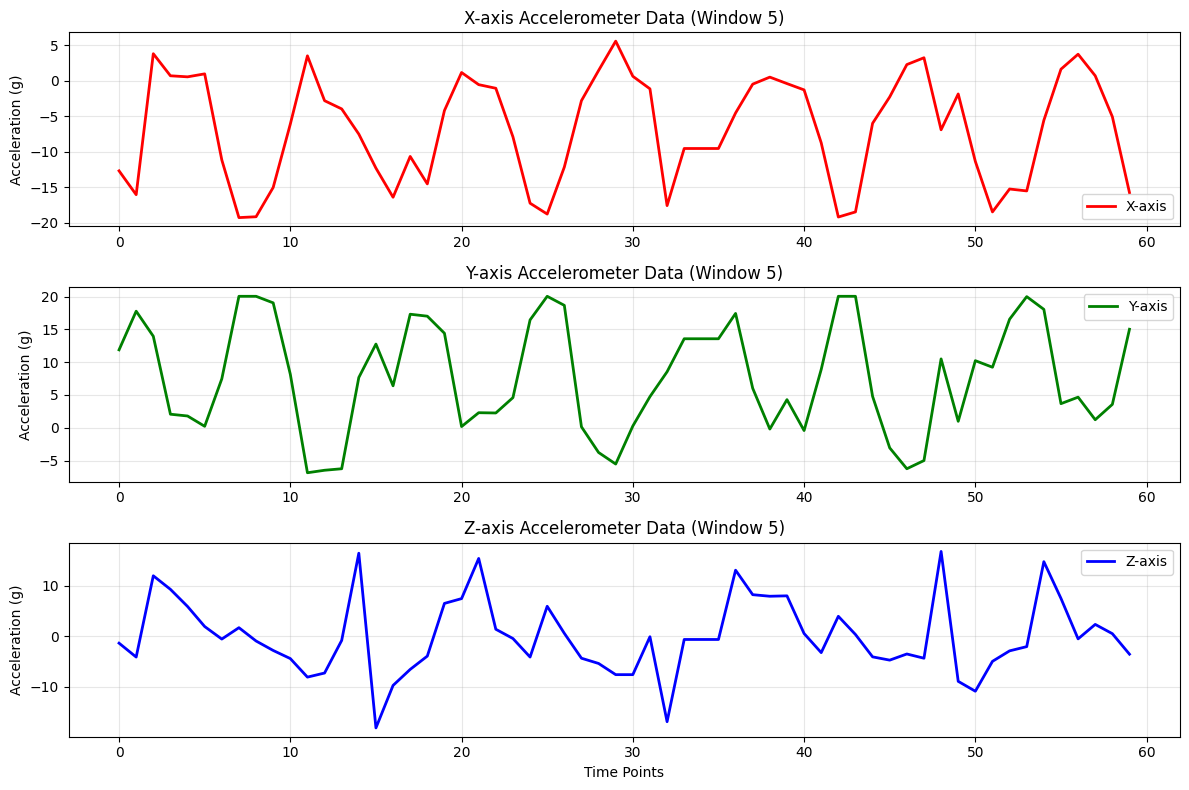

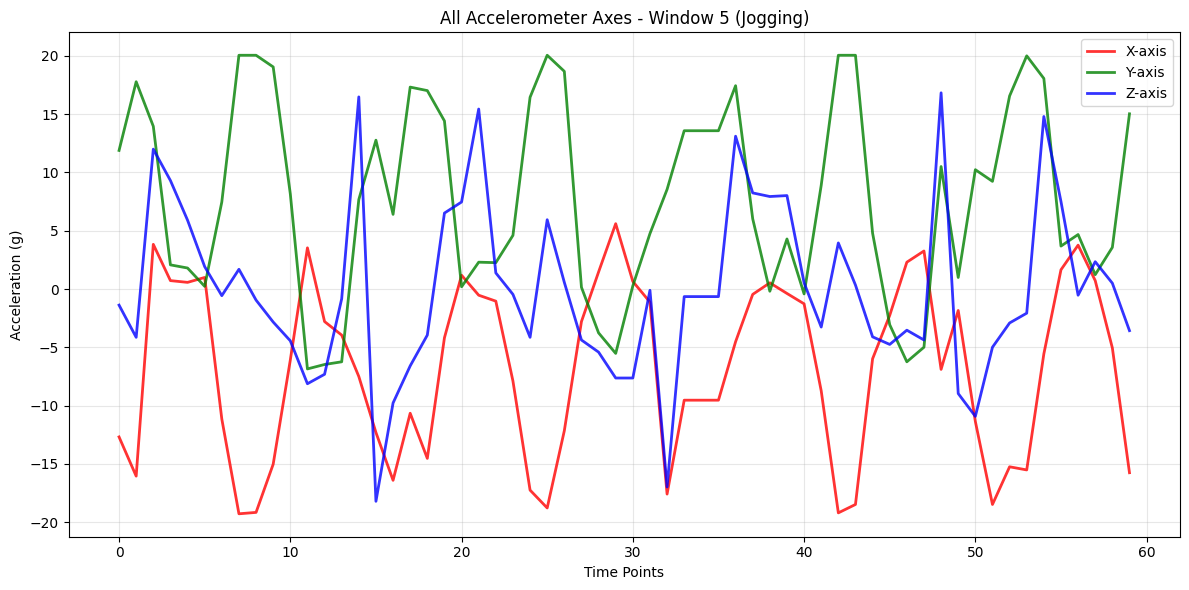


📈 ACCELEROMETER STATISTICS:
   X-axis: Mean=-6.759, Std=7.460
   Y-axis: Mean=7.806, Std=8.301
   Z-axis: Mean=-0.052, Std=7.438
   Magnitude: Mean=14.913, Std=8.007


📊 OVERALL WINDOW ANALYSIS SUMMARY
🧠 CONCEPT PREDICTION ACCURACY (first 5 windows):
   Periodicity: 1.000 (100.0%)
   Temporal Stability: 0.800 (80.0%)
   Coordination: 1.000 (100.0%)

 ACTIVITY PREDICTION ACCURACY (first 5 windows):
   CNN→LR: 0.800 (80.0%)
   GT→LR: 0.600 (60.0%)


In [82]:
print("="*80)
print("DETAILED WINDOW-BY-WINDOW ANALYSIS")
print("="*80)

reverse_activity_mapping = {v: k for k, v in activity_mapping.items()}

n_windows_to_analyze = min(5, len(X_test_filtered))
print(f"Analyzing {n_windows_to_analyze} test windows...\n")

for i in range(n_windows_to_analyze):
    print(f"📱 WINDOW {i+1}/{n_windows_to_analyze}")
    print("-" * 50)
    
    row = rows_filtered[i]
    print(f"👤 User: {row['user']}")
    print(f"⏰ Time: {row['start_time']:.1f}s - {row['end_time']:.1f}s")
    print(f"🏃 Activity: {row['activity']} (Ground Truth)")
    
    print(f"\n📊 GROUND TRUTH CONCEPTS:")
    print(f"   Periodicity: {row['periodicity']}")
    print(f"   Temporal Stability: {row['temporal_stability']}")
    print(f"   Coordination: {row['coordination']}")
    print(f"   Motion Intensity: {row['motion_intensity']:.4f}")
    print(f"   Vertical Dominance: {row['vertical_dominance']:.4f}")
    
    print(f"\n🧠 CNN PREDICTED CONCEPTS:")
    print(f"   Periodicity: {periodicity_pred[i]} (confidence: {np.max(predictions[0][i]):.3f})")
    print(f"   Temporal Stability: {temporal_stability_pred[i]} (confidence: {np.max(predictions[1][i]):.3f})")
    print(f"   Coordination: {coordination_pred[i]} (confidence: {np.max(predictions[2][i]):.3f})")
    print(f"   Motion Intensity: {motion_intensity_pred[i]:.4f}")
    print(f"   Vertical Dominance: {vertical_dominance_pred[i]:.4f}")
    
    periodicity_correct = (periodicity_pred[i] == int(row['periodicity'] * 2))
    temporal_stability_correct = (temporal_stability_pred[i] == int(row['temporal_stability'] * 2))
    coordination_correct = (coordination_pred[i] == int(row['coordination'] * 2))
    motion_intensity_error = abs(motion_intensity_pred[i] - row['motion_intensity'])
    vertical_dominance_error = abs(vertical_dominance_pred[i] - row['vertical_dominance'])
    
    print(f"\n✅ CONCEPT PREDICTION ACCURACY:")
    print(f"   Periodicity: {'✅' if periodicity_correct else '❌'}")
    print(f"   Temporal Stability: {'✅' if temporal_stability_correct else '❌'}")
    print(f"   Coordination: {'✅' if coordination_correct else '❌'}")
    print(f"   Motion Intensity: Error = {motion_intensity_error:.4f}")
    print(f"   Vertical Dominance: Error = {vertical_dominance_error:.4f}")
    
    gt_activity = row['activity']
    predicted_activity_cnn_lr = reverse_activity_mapping[y_pred_lr_cnn[i]]
    predicted_activity_gt_lr = reverse_activity_mapping[y_pred_lr_gt_original[i]]
    
    print(f"\nACTIVITY PREDICTIONS:")
    print(f"   Ground Truth: {gt_activity}")
    print(f"   CNN→LR: {predicted_activity_cnn_lr} (confidence: {np.max(y_pred_proba_lr_cnn[i]):.3f})")
    print(f"   GT→LR: {predicted_activity_gt_lr} (confidence: {np.max(y_pred_proba_lr_gt_original[i]):.3f})")
    
    # Activity prediction accuracy
    cnn_lr_correct = (y_pred_lr_cnn[i] == y_test_original[i])
    gt_lr_correct = (y_pred_lr_gt_original[i] == y_test_original[i])
    
    print(f"\n🎯 ACTIVITY PREDICTION ACCURACY:")
    print(f"   CNN→LR: {'✅' if cnn_lr_correct else '❌'}")
    print(f"   GT→LR: {'✅' if gt_lr_correct else '❌'}")
    
    # Show top 3 activity probabilities
    top3_indices = np.argsort(y_pred_proba_lr_cnn[i])[-3:][::-1]
    print(f"\n📈 TOP 3 ACTIVITY PROBABILITIES (CNN→LR):")
    for j, idx in enumerate(top3_indices):
        activity_name = reverse_activity_mapping[idx]
        prob = y_pred_proba_lr_cnn[i][idx]
        print(f"   {j+1}. {activity_name}: {prob:.3f}")
    
    # Plot the XYZ accelerometer data for this window
    print(f"\n📊 ACCELEROMETER DATA VISUALIZATION:")
    fig, axes = plt.subplots(3, 1, figsize=(12, 8))
    
    # Get the sensor data for this window
    window_data = X_test_filtered[i]  # Shape: (60, 3)
    time_points = np.arange(len(window_data))
    
    # Plot X, Y, Z axes
    axes[0].plot(time_points, window_data[:, 0], 'r-', linewidth=2, label='X-axis')
    axes[0].set_title(f'X-axis Accelerometer Data (Window {i+1})')
    axes[0].set_ylabel('Acceleration (g)')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    
    axes[1].plot(time_points, window_data[:, 1], 'g-', linewidth=2, label='Y-axis')
    axes[1].set_title(f'Y-axis Accelerometer Data (Window {i+1})')
    axes[1].set_ylabel('Acceleration (g)')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    axes[2].plot(time_points, window_data[:, 2], 'b-', linewidth=2, label='Z-axis')
    axes[2].set_title(f'Z-axis Accelerometer Data (Window {i+1})')
    axes[2].set_xlabel('Time Points')
    axes[2].set_ylabel('Acceleration (g)')
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Also plot all three axes together for comparison
    plt.figure(figsize=(12, 6))
    plt.plot(time_points, window_data[:, 0], 'r-', linewidth=2, label='X-axis', alpha=0.8)
    plt.plot(time_points, window_data[:, 1], 'g-', linewidth=2, label='Y-axis', alpha=0.8)
    plt.plot(time_points, window_data[:, 2], 'b-', linewidth=2, label='Z-axis', alpha=0.8)
    plt.title(f'All Accelerometer Axes - Window {i+1} ({row["activity"]})')
    plt.xlabel('Time Points')
    plt.ylabel('Acceleration (g)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Calculate and display some basic statistics
    x_mean, x_std = np.mean(window_data[:, 0]), np.std(window_data[:, 0])
    y_mean, y_std = np.mean(window_data[:, 1]), np.std(window_data[:, 1])
    z_mean, z_std = np.mean(window_data[:, 2]), np.std(window_data[:, 2])
    
    print(f"\n📈 ACCELEROMETER STATISTICS:")
    print(f"   X-axis: Mean={x_mean:.3f}, Std={x_std:.3f}")
    print(f"   Y-axis: Mean={y_mean:.3f}, Std={y_std:.3f}")
    print(f"   Z-axis: Mean={z_mean:.3f}, Std={z_std:.3f}")
    
    # Calculate magnitude
    magnitude = np.sqrt(np.sum(window_data**2, axis=1))
    mag_mean, mag_std = np.mean(magnitude), np.std(magnitude)
    print(f"   Magnitude: Mean={mag_mean:.3f}, Std={mag_std:.3f}")
    
    print("\n" + "="*50)

# Overall summary
print(f"\n📊 OVERALL WINDOW ANALYSIS SUMMARY")
print("="*50)

# Calculate overall concept prediction accuracy
concept_accuracy_periodicity = np.mean([periodicity_pred[i] == int(rows_filtered[i]['periodicity'] * 2) for i in range(n_windows_to_analyze)])
concept_accuracy_temporal = np.mean([temporal_stability_pred[i] == int(rows_filtered[i]['temporal_stability'] * 2) for i in range(n_windows_to_analyze)])
concept_accuracy_coordination = np.mean([coordination_pred[i] == int(rows_filtered[i]['coordination'] * 2) for i in range(n_windows_to_analyze)])

print(f"🧠 CONCEPT PREDICTION ACCURACY (first {n_windows_to_analyze} windows):")
print(f"   Periodicity: {concept_accuracy_periodicity:.3f} ({concept_accuracy_periodicity*100:.1f}%)")
print(f"   Temporal Stability: {concept_accuracy_temporal:.3f} ({concept_accuracy_temporal*100:.1f}%)")
print(f"   Coordination: {concept_accuracy_coordination:.3f} ({concept_accuracy_coordination*100:.1f}%)")

# Calculate overall activity prediction accuracy
activity_accuracy_cnn_lr = np.mean([y_pred_lr_cnn[i] == y_test_original[i] for i in range(n_windows_to_analyze)])
activity_accuracy_gt_lr = np.mean([y_pred_lr_gt_original[i] == y_test_original[i] for i in range(n_windows_to_analyze)])

print(f"\n ACTIVITY PREDICTION ACCURACY (first {n_windows_to_analyze} windows):")
print(f"   CNN→LR: {activity_accuracy_cnn_lr:.3f} ({activity_accuracy_cnn_lr*100:.1f}%)")
print(f"   GT→LR: {activity_accuracy_gt_lr:.3f} ({activity_accuracy_gt_lr*100:.1f}%)")